# Movie Recommendation Project

## Installing the libraries and the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df_movies = pd.read_csv('movies.csv')
print(df_movies.info())
df_movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
df_movies.drop_duplicates(inplace=True)

In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [5]:
df_ratings = pd.read_csv('ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [6]:
df_tags = pd.read_csv('tags.csv')
df_tags

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455
...,...,...,...,...
1093355,162521,66934,Neil Patrick Harris,1427311611
1093356,162521,103341,cornetto trilogy,1427311259
1093357,162534,189169,comedy,1527518175
1093358,162534,189169,disabled,1527518181


In [7]:
df_links = pd.read_csv('links.csv')
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
df_genscores = pd.read_csv('genome-scores.csv')
print(df_genscores.info())
df_genscores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB
None


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [9]:
df_gentags = pd.read_csv('genome-tags.csv')
df_gentags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


Now we have all the datasets loaded in, where some may be kept and some may be dropped, nbut it is nicfe to be able to see them all in the same place so that preprocessing can be easier while also more thorough.

## Data Prepocessing

In [10]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


I'm not entirely sure what the timestamp is and therefore how useful it will be in this project, so I will be dropping the column.

In [11]:
df_ratings.drop(labels='timestamp', axis=1, inplace=True)

In [12]:
df_ratings.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [13]:
df_ratings_tomerge = df_ratings.groupby(['movieId'], )['rating'].mean()
df_ratings_tomerge

movieId
1         3.893708
2         3.251527
3         3.142028
4         2.853547
5         3.058434
            ...   
209157    1.500000
209159    3.000000
209163    4.500000
209169    3.000000
209171    3.000000
Name: rating, Length: 59047, dtype: float64

In [14]:
df_movies_complete = pd.merge(left=df_movies, right=df_ratings_tomerge, left_on='movieId', right_index=True, how='right')
df_movies_complete

,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547
4,5,Father of the Bride Part II (1995),Comedy,3.058434
...,...,...,...,...
62418,209157,We (2018),Drama,1.500000
62419,209159,Window of the Soul (2001),Documentary,3.000000
62420,209163,Bad Poems (2018),Comedy|Drama,4.500000
62421,209169,A Girl Thing (2001),(no genres listed),3.000000


In [15]:
df_tags.drop(labels='timestamp', axis=1, inplace=True)

In [16]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   userId   1093360 non-null  int64 
 1   movieId  1093360 non-null  int64 
 2   tag      1093344 non-null  object
dtypes: int64(2), object(1)
memory usage: 25.0+ MB


I will be focusing on the datasets titled 'ratings.csv', 'movies.csv' and 'tags.csv'

In [17]:
df_tags.head()

,userId,movieId,tag
0,3,260,classic
1,3,260,sci-fi
2,4,1732,dark comedy
3,4,1732,great dialogue
4,4,7569,so bad it's good


In [18]:
df_tags_tomerge = df_tags.groupby(['movieId'], )['tag'].apply(list)
df_tags_tomerge

movieId
1         [Owned, imdb top 250, Pixar, Pixar, time trave...
2         [Robin Williams, time travel, fantasy, based o...
3         [funny, best friend, duringcreditsstinger, fis...
4         [based on novel or book, chick flick, divorce,...
5         [aging, baby, confidence, contraception, daugh...
                                ...                        
208813                                         [might like]
208933               [black and white, deal with the devil]
209035    [computer animation, Japan, mass behavior, mas...
209037    [chameleon, computer animation, gluttony, humo...
209063    [black, education, friends schools, independen...
Name: tag, Length: 45251, dtype: object

In [19]:
df_movies_completed = pd.merge(left=df_movies_complete, right=df_tags_tomerge, left_on='movieId', right_index=True, how='left')
df_movies_completed

,movieId,title,genres,rating,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,"[Owned, imdb top 250, Pixar, Pixar, time trave..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,"[Robin Williams, time travel, fantasy, based o..."
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,"[funny, best friend, duringcreditsstinger, fis..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,"[based on novel or book, chick flick, divorce,..."
4,5,Father of the Bride Part II (1995),Comedy,3.058434,"[aging, baby, confidence, contraception, daugh..."
...,...,...,...,...,...
62418,209157,We (2018),Drama,1.500000,NaN
62419,209159,Window of the Soul (2001),Documentary,3.000000,NaN
62420,209163,Bad Poems (2018),Comedy|Drama,4.500000,NaN
62421,209169,A Girl Thing (2001),(no genres listed),3.000000,NaN


In [20]:
df_movies_completed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59047 entries, 0 to 62422
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  59047 non-null  int64  
 1   title    59047 non-null  object 
 2   genres   59047 non-null  object 
 3   rating   59047 non-null  float64
 4   tag      41875 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.7+ MB


In [21]:
df_movies_completed.describe()

,movieId,rating
count,59047.000000,59047.000000
mean,120692.748065,3.071374
std,64452.508194,0.739840
min,1.000000,0.500000
25%,78277.000000,2.687500
50%,136782.000000,3.150000
75%,173812.000000,3.500000
max,209171.000000,5.000000


May potentially drop null values later on, after analysis.

## Exploratory Data Analysis

In [22]:
## see what the data looks like on a more simple scale
print('No. of Movies: ', df_movies.movieId.nunique())
print('No. of Movies Rated: ', df_ratings.movieId.nunique())
print('No. of Users: ', df_ratings.userId.nunique())
print('No. of Ratings: ', df_ratings.rating.count())
print('No of User Comments: ', df_tags.tag.nunique())
print('No of Movies with Comments: ', df_tags.movieId.nunique())
print('Percentage of Users with Comments: ', (df_tags.tag.nunique()/df_ratings.userId.nunique())*100, '%')
print('Percentage of Movies with Comments: ', (df_tags.movieId.nunique()/df_ratings.movieId.nunique())*100, '%')


No. of Movies:  62423


No. of Movies Rated:  59047
No. of Users:  162541
No. of Ratings:  25000095
No of User Comments:  73050
No of Movies with Comments:  45251
Percentage of Users with Comments:  44.942506813665474 %
Percentage of Movies with Comments:  76.63556150185445 %


For the sake of analysis and visualisation, I will be making copies of the datasets and manipulating them with the purpose of  drawing more out of it.

In [23]:
dfr = df_ratings.copy()
dfm = df_movies.copy()
dft = df_tags.copy()

In [24]:
dfr

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5
...,...,...,...
25000090,162541,50872,4.5
25000091,162541,55768,2.5
25000092,162541,56176,2.0
25000093,162541,58559,4.0


In [25]:
dfm

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [26]:
dft

,userId,movieId,tag
0,3,260,classic
1,3,260,sci-fi
2,4,1732,dark comedy
3,4,1732,great dialogue
4,4,7569,so bad it's good
...,...,...,...
1093355,162521,66934,Neil Patrick Harris
1093356,162521,103341,cornetto trilogy
1093357,162534,189169,comedy
1093358,162534,189169,disabled


In [27]:
clean_genre = dfm['genres'].str.split(pat='|', expand=True).fillna(0)
clean_genre

,0,1,2,3,4,5,6,7,8,9
0,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0
1,Adventure,Children,Fantasy,0,0,0,0,0,0,0
2,Comedy,Romance,0,0,0,0,0,0,0,0
3,Comedy,Drama,Romance,0,0,0,0,0,0,0
4,Comedy,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
62418,Drama,0,0,0,0,0,0,0,0,0
62419,Documentary,0,0,0,0,0,0,0,0,0
62420,Comedy,Drama,0,0,0,0,0,0,0,0
62421,(no genres listed),0,0,0,0,0,0,0,0,0


In [28]:
clean_genre.columns = ['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10']
clean_genre

,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
0,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0
1,Adventure,Children,Fantasy,0,0,0,0,0,0,0
2,Comedy,Romance,0,0,0,0,0,0,0,0
3,Comedy,Drama,Romance,0,0,0,0,0,0,0
4,Comedy,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
62418,Drama,0,0,0,0,0,0,0,0,0
62419,Documentary,0,0,0,0,0,0,0,0,0
62420,Comedy,Drama,0,0,0,0,0,0,0,0
62421,(no genres listed),0,0,0,0,0,0,0,0,0


In [29]:
cols = clean_genre.columns
clean_genre[cols] = clean_genre[cols].astype('category')
cg = clean_genre.copy()

In [30]:
cg

,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
0,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0
1,Adventure,Children,Fantasy,0,0,0,0,0,0,0
2,Comedy,Romance,0,0,0,0,0,0,0,0
3,Comedy,Drama,Romance,0,0,0,0,0,0,0
4,Comedy,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
62418,Drama,0,0,0,0,0,0,0,0,0
62419,Documentary,0,0,0,0,0,0,0,0,0
62420,Comedy,Drama,0,0,0,0,0,0,0,0
62421,(no genres listed),0,0,0,0,0,0,0,0,0


In [31]:
cat_columns = cg.select_dtypes(['category']).columns
cg

,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
0,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0
1,Adventure,Children,Fantasy,0,0,0,0,0,0,0
2,Comedy,Romance,0,0,0,0,0,0,0,0
3,Comedy,Drama,Romance,0,0,0,0,0,0,0
4,Comedy,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
62418,Drama,0,0,0,0,0,0,0,0,0
62419,Documentary,0,0,0,0,0,0,0,0,0
62420,Comedy,Drama,0,0,0,0,0,0,0,0
62421,(no genres listed),0,0,0,0,0,0,0,0,0


In [32]:
## putting it back into the original copied dataset
dfm[cols] = clean_genre[cols]
dfm.head()

,movieId,title,genres,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure,Children,Fantasy,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy,Romance,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy,Drama,Romance,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,Comedy,0,0,0,0,0,0,0,0,0


In [33]:
## now to also make extra column for the year
sep_year = dfm['title'].str.findall('\((\d{4})\)').str.get(0)
dfm['Year'] = sep_year
dfm.head()

<>:2: SyntaxWarning: invalid escape sequence '\('
<>:2: SyntaxWarning: invalid escape sequence '\('
C:\Users\Me\AppData\Local\Temp\ipykernel_4320\1244892922.py:2: SyntaxWarning: invalid escape sequence '\('
  sep_year = dfm['title'].str.findall('\((\d{4})\)').str.get(0)


,movieId,title,genres,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure,Children,Fantasy,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy,Romance,0,0,0,0,0,0,0,0,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy,Drama,Romance,0,0,0,0,0,0,0,1995
4,5,Father of the Bride Part II (1995),Comedy,Comedy,0,0,0,0,0,0,0,0,0,1995


In [34]:
average_ratings = dfr.groupby(['movieId'], )['rating'].mean().reset_index()
average_ratings = pd.DataFrame(average_ratings)

number_ratings = dfr.groupby(['movieId'], )['rating'].count().reset_index()
number_ratings = pd.DataFrame(number_ratings)
number_ratings.rename({'rating': 'rating_count'}, axis=1, inplace=True)

analysis_movies = average_ratings.merge(number_ratings, on='movieId', how='inner')

analysis_movies

,movieId,rating,rating_count
0,1,3.893708,57309
1,2,3.251527,24228
2,3,3.142028,11804
3,4,2.853547,2523
4,5,3.058434,11714
...,...,...,...
59042,209157,1.500000,1
59043,209159,3.000000,1
59044,209163,4.500000,1
59045,209169,3.000000,1


In [35]:
number_tags = dft.groupby(['movieId'])['tag'].count().reset_index()
number_tags = pd.DataFrame(number_tags)
number_tags.rename({'tag': 'tag_count'}, axis=1, inplace=True)

number_tags

,movieId,tag_count
0,1,697
1,2,180
2,3,29
3,4,11
4,5,24
...,...,...
45246,208813,1
45247,208933,2
45248,209035,6
45249,209037,5


In [36]:
dfm = dfm.merge(analysis_movies, on='movieId', how='inner')
dfm

,movieId,title,genres,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,Year,rating,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0,1995,3.893708,57309
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure,Children,Fantasy,0,0,0,0,0,0,0,1995,3.251527,24228
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy,Romance,0,0,0,0,0,0,0,0,1995,3.142028,11804
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy,Drama,Romance,0,0,0,0,0,0,0,1995,2.853547,2523
4,5,Father of the Bride Part II (1995),Comedy,Comedy,0,0,0,0,0,0,0,0,0,1995,3.058434,11714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59042,209157,We (2018),Drama,Drama,0,0,0,0,0,0,0,0,0,2018,1.500000,1
59043,209159,Window of the Soul (2001),Documentary,Documentary,0,0,0,0,0,0,0,0,0,2001,3.000000,1
59044,209163,Bad Poems (2018),Comedy|Drama,Comedy,Drama,0,0,0,0,0,0,0,0,2018,4.500000,1
59045,209169,A Girl Thing (2001),(no genres listed),(no genres listed),0,0,0,0,0,0,0,0,0,2001,3.000000,1


In [37]:
cols_for_tags = ['movieId', 'genre1']
dftt = dfm[cols_for_tags]
dft = dft.merge(dftt, on='movieId', how='inner')
dft

,userId,movieId,tag,genre1
0,3,260,classic,Action
1,3,260,sci-fi,Action
2,110,260,action,Action
3,110,260,adventure,Action
4,110,260,fantasy,Action
...,...,...,...,...
1083523,162174,163462,india,Action
1083524,162174,163462,indian,Action
1083525,162534,189169,comedy,Comedy
1083526,162534,189169,disabled,Comedy


## Visualisations

C:\Users\Me\AppData\Local\Temp\ipykernel_4320\74587599.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfm.Year)


(1940.0, 2020.0)

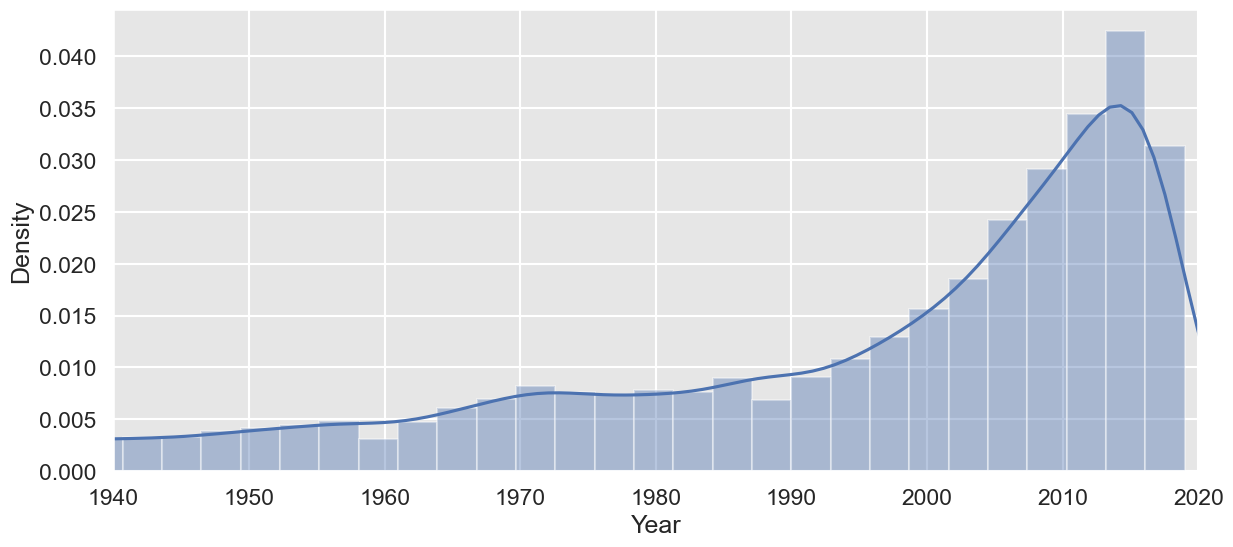

In [38]:
sns.set(rc={'figure.figsize':(14, 6)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"}) #sns.axes_style("whitegrid")

sns.distplot(dfm.Year)
plt.xlim(1940, 2020)

In [39]:
genre = dfm.genre1.value_counts()
genre = pd.DataFrame(genre)
genre = genre.reset_index()
genre.rename({'count': 'number', 'genre1':'Genre'}, axis=1, inplace=True)

In [40]:
genre

,Genre,number
0,Drama,14624
1,Comedy,12936
2,Action,6913
3,Documentary,5068
4,(no genres listed),4568
5,Horror,3300
6,Crime,2845
7,Adventure,2319
8,Animation,2074
9,Children,1323


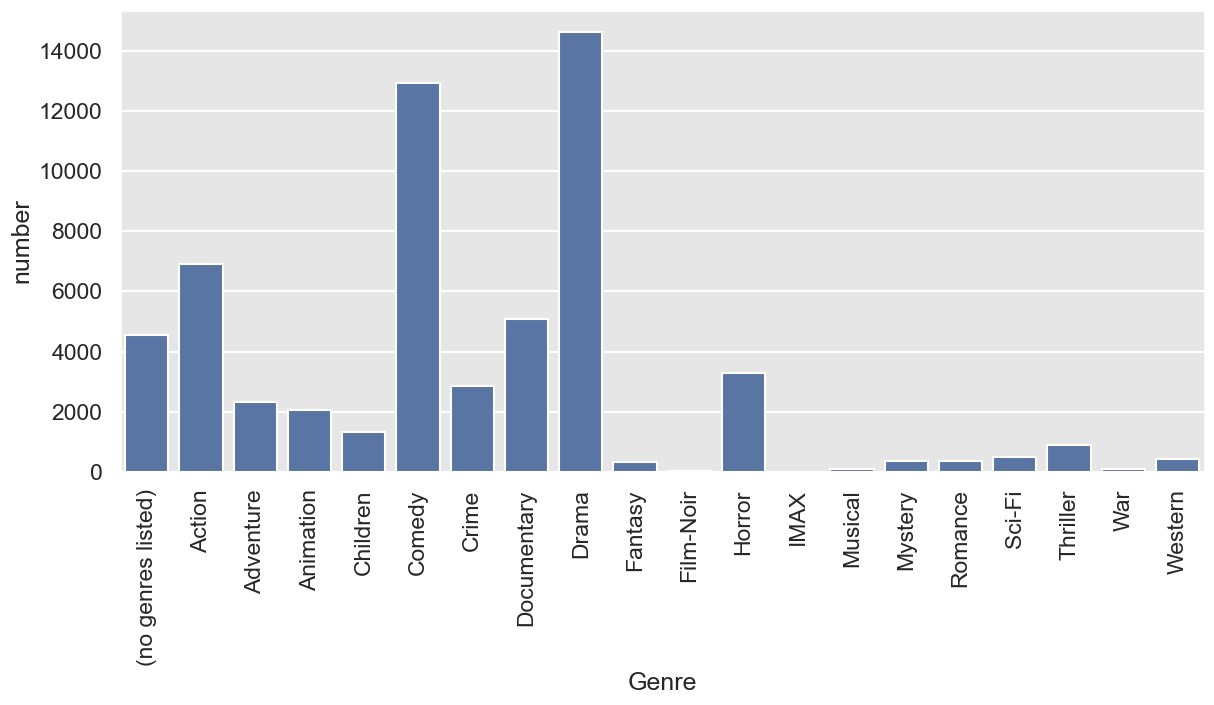

In [41]:
sns.barplot(x = genre.Genre, y=genre.number)
plt.xticks(rotation=90)
plt.show()

In [42]:
genre1 = dfm.groupby('genre1')['rating_count'].mean()
genre1 = pd.DataFrame(genre1)
genre1 = genre1.reset_index()
genre1.rename({'rating_count':'number_of_ratings'}, axis=1, inplace=True)

C:\Users\Me\AppData\Local\Temp\ipykernel_4320\2338708916.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre1 = dfm.groupby('genre1')['rating_count'].mean()


Text(0.5, 0, '# of Ratings by Genre')

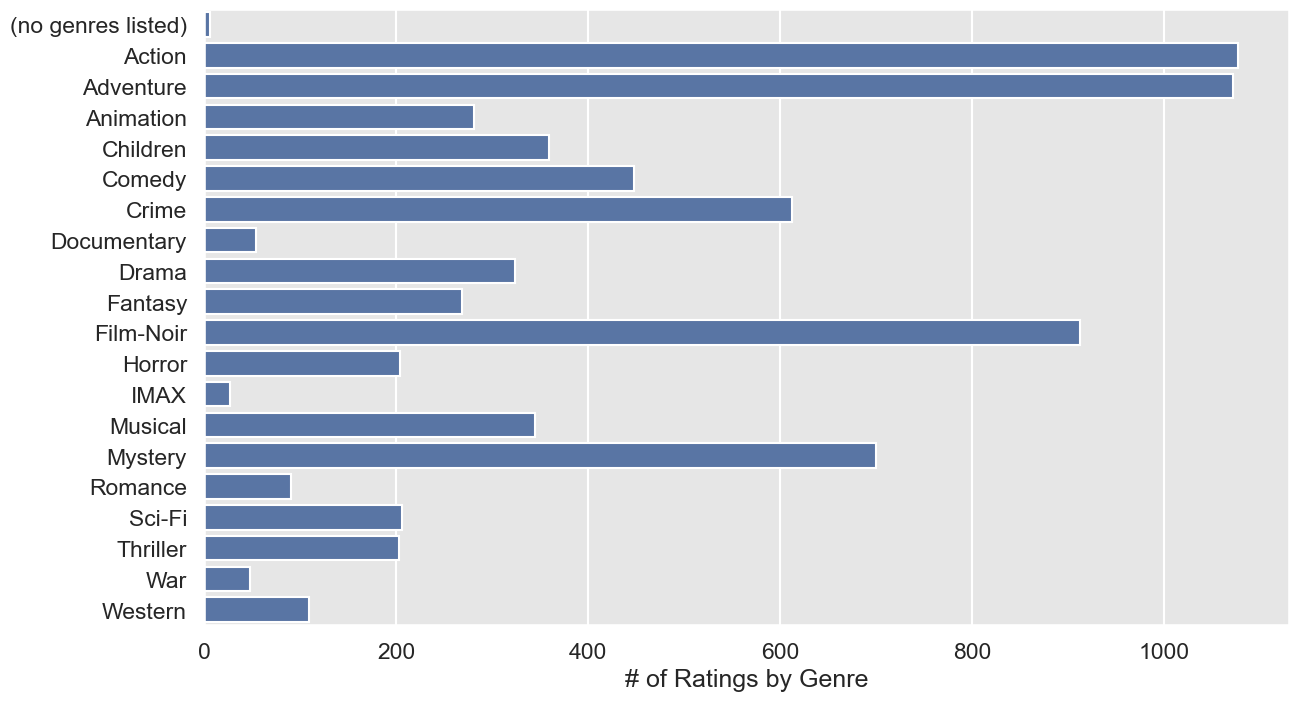

In [43]:
sns.set(rc={'figure.figsize':(14, 8)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.barplot(x = genre1.number_of_ratings, y=genre1.genre1)
plt.ylabel("")
plt.xlabel('# of Ratings by Genre')

In [44]:
cols = ['movieId', 'genre1']
b1 = dfm[cols]
box_genre = dfr.merge(b1, on='movieId', how='inner')
box_genre

,userId,movieId,rating,genre1
0,1,296,5.0,Comedy
1,3,296,5.0,Comedy
2,4,296,4.0,Comedy
3,5,296,4.0,Comedy
4,7,296,4.0,Comedy
...,...,...,...,...
25000090,162358,200192,2.0,(no genres listed)
25000091,162358,200194,2.0,Action
25000092,162386,139970,3.5,Comedy
25000093,162386,200726,4.0,Children


Text(0.5, 0, 'Genres')

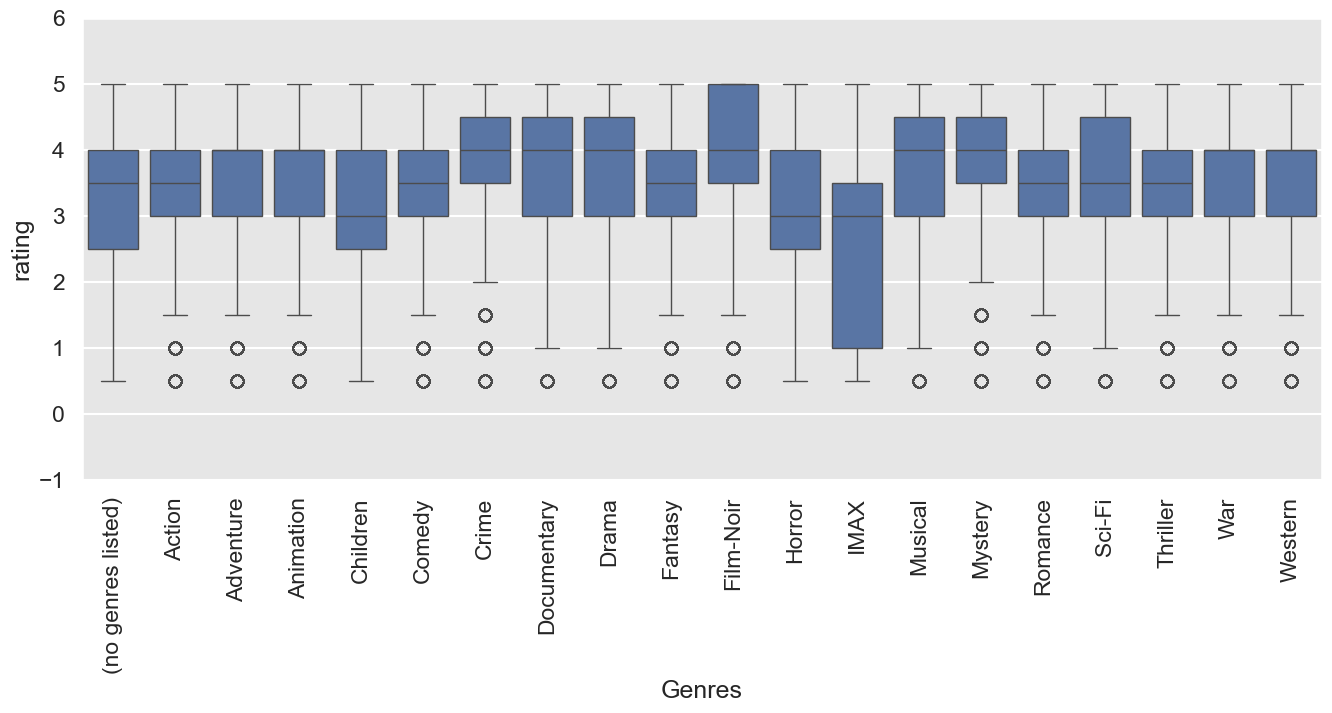

In [45]:
sns.set(rc={'figure.figsize':(16, 6)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.boxplot(x=box_genre.genre1, y=box_genre.rating, data=box_genre)
plt.xticks(rotation=90)
plt.ylim(-1, 6)
plt.xlabel('Genres')

C:\Users\Me\AppData\Local\Temp\ipykernel_4320\2727303381.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=box_genre.genre1, y=box_genre.rating, data=box_genre, palette='flare')


Text(0.5, 0, 'Genres')

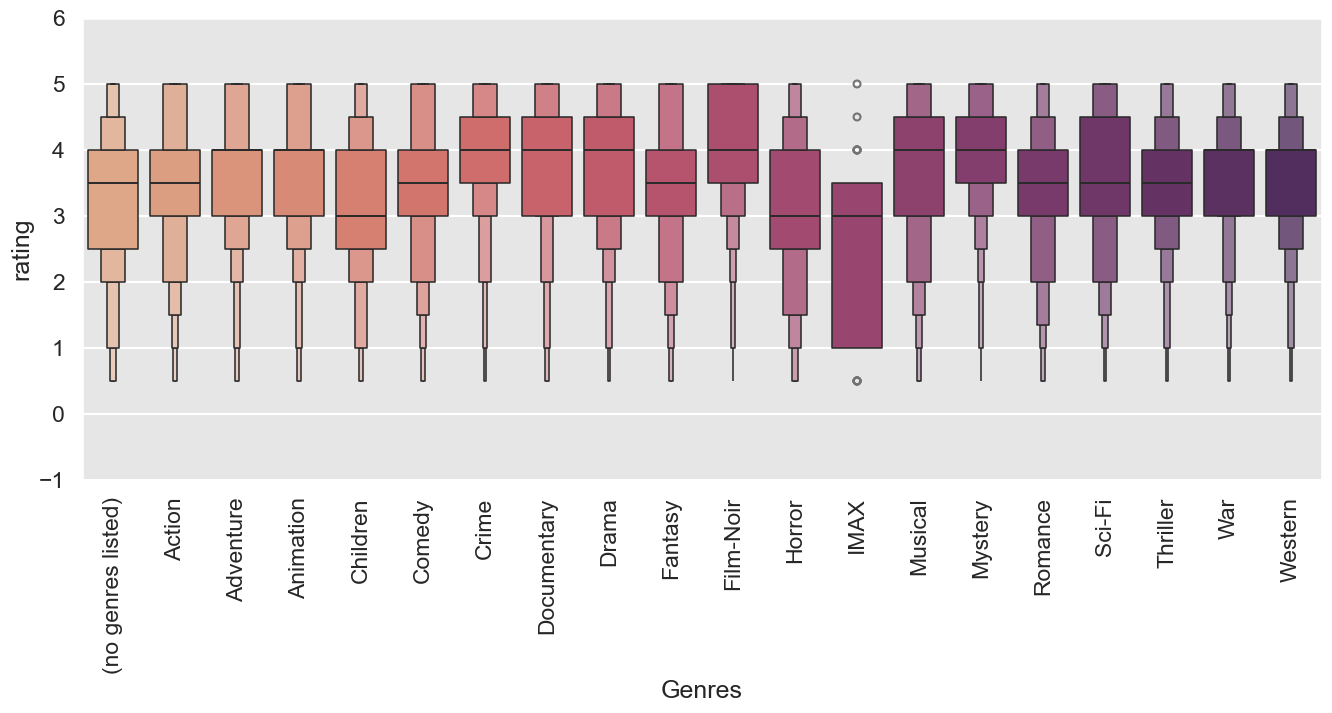

In [46]:
sns.set(rc={'figure.figsize':(16, 6)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.boxenplot(x=box_genre.genre1, y=box_genre.rating, data=box_genre, palette='flare')
plt.xticks(rotation=90)
plt.ylim(-1, 6)
plt.xlabel('Genres')

In [47]:
genre_by_year = dfm.groupby(['Year', 'genre1'])['title'].count().reset_index()
genre_by_year  = pd.DataFrame(genre_by_year)
genre_by_year

C:\Users\Me\AppData\Local\Temp\ipykernel_4320\3665016572.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre_by_year = dfm.groupby(['Year', 'genre1'])['title'].count().reset_index()


,Year,genre1,title
0,1874,(no genres listed),0
1,1874,Action,0
2,1874,Adventure,0
3,1874,Animation,0
4,1874,Children,0
...,...,...,...
2695,2019,Romance,7
2696,2019,Sci-Fi,13
2697,2019,Thriller,30
2698,2019,War,1


In [48]:
genre_by_year1 = genre_by_year[genre_by_year['Year']>='2000']
genre_by_year1

,Year,genre1,title
2300,2000,(no genres listed),72
2301,2000,Action,90
2302,2000,Adventure,19
2303,2000,Animation,31
2304,2000,Children,27
...,...,...,...
2695,2019,Romance,7
2696,2019,Sci-Fi,13
2697,2019,Thriller,30
2698,2019,War,1


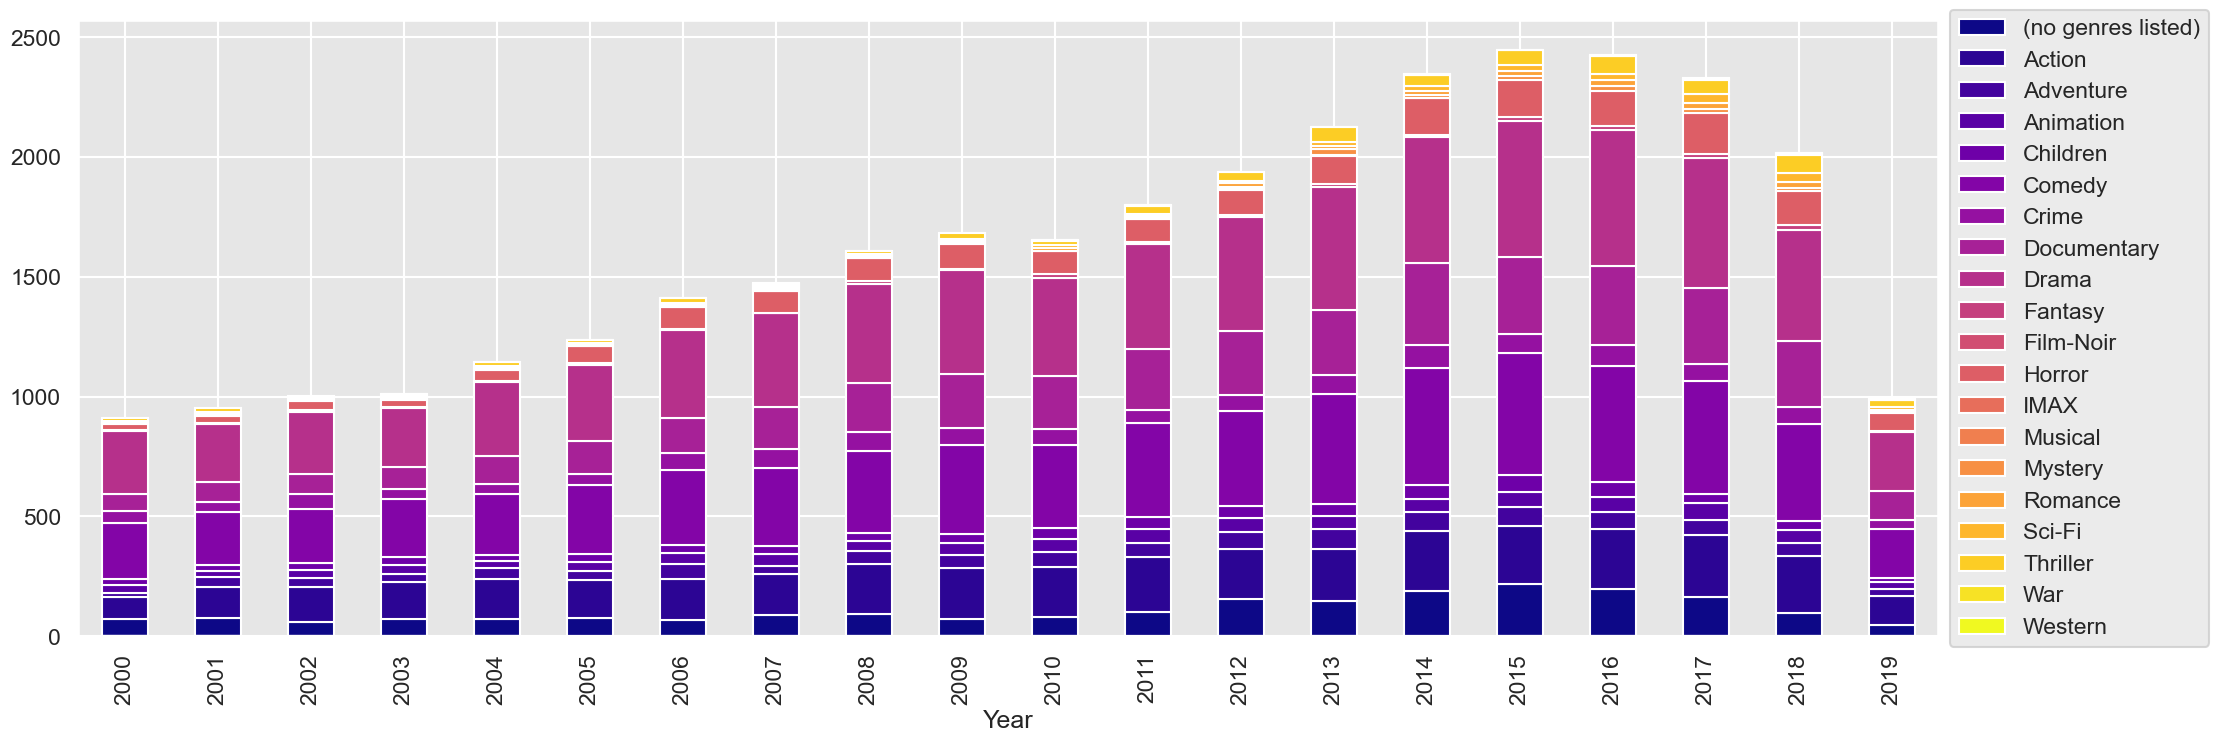

In [49]:
sns.set(rc={'figure.figsize':(24, 8)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_pivot = pd.pivot_table(genre_by_year1, index='Year', columns='genre1', values='title')
df_pivot.plot.bar(stacked=True, colormap='plasma')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [50]:
top10_mov = dfm.sort_values(by=['rating'], ascending=False)
cols = ['movieId', 'title', 'rating']
top10mov = top10_mov[cols]
top10mov.head(10)

,movieId,title,rating
29523,136782,The Girl is in Trouble (2015),5.0
49654,186119,A Gift Horse (2015),5.0
29643,137032,The Perfect Neighbor (2005),5.0
49041,184643,Relentless (2018),5.0
29646,137038,The Perfect Wife (2001),5.0
54556,197231,The Harrow (2016),5.0
49052,184669,Devil's Whisper (2017),5.0
29651,137048,Perfect Child (2007),5.0
29652,137050,The Rival (2006),5.0
29653,137052,A Job to Kill For (2006),5.0


In [51]:
top10_mov[top10_mov['rating']<5].head(100)

,movieId,title,genres,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,Year,rating,rating_count
46809,179541,An Uncommon Grace (2017),Drama|Romance,Drama,Romance,0,0,0,0,0,0,0,0,2017,4.833333,3
46895,179721,Belle and the Beast (2007),Drama|Romance,Drama,Romance,0,0,0,0,0,0,0,0,2007,4.833333,3
46863,179649,Horse Crazy (2001),Children|Drama,Children,Drama,0,0,0,0,0,0,0,0,2001,4.833333,3
31997,143007,A Horse for Summer (2015),(no genres listed),(no genres listed),0,0,0,0,0,0,0,0,0,2015,4.833333,3
50086,187049,Manieggs - Revenge of the Hard Egg (2014),Animation,Animation,0,0,0,0,0,0,0,0,0,2014,4.750000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46866,179657,All I Can (2011),Documentary,Documentary,0,0,0,0,0,0,0,0,0,2011,4.500000,1
42874,170849,In Memory of My Father (2005),Comedy|Drama,Comedy,Drama,0,0,0,0,0,0,0,0,2005,4.500000,1
42532,170060,The Amorous Prawn (1962),Comedy,Comedy,0,0,0,0,0,0,0,0,0,1962,4.500000,1
34836,150637,Don Quixote (1957),Drama,Drama,0,0,0,0,0,0,0,0,0,1957,4.500000,3


In [52]:
top10_movr = dfm.sort_values(by=['rating_count'], ascending=False)
top10_movr = top10_movr.head(10)
cols = ['movieId', 'title']
top10movr = top10_movr[cols]
top10movr.head()

,movieId,title
351,356,Forrest Gump (1994)
314,318,"Shawshank Redemption, The (1994)"
292,296,Pulp Fiction (1994)
585,593,"Silence of the Lambs, The (1991)"
2480,2571,"Matrix, The (1999)"


In [53]:
top10movr = top10movr.merge(dfr, on = 'movieId', how='inner')

In [54]:
top10movr.head()

,movieId,title,userId,rating
0,356,Forrest Gump (1994),2,4.5
1,356,Forrest Gump (1994),3,4.0
2,356,Forrest Gump (1994),5,4.0
3,356,Forrest Gump (1994),8,5.0
4,356,Forrest Gump (1994),9,5.0


C:\Users\Me\AppData\Local\Temp\ipykernel_4320\426687781.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='title', y='rating', data=top10movr, palette ='plasma')


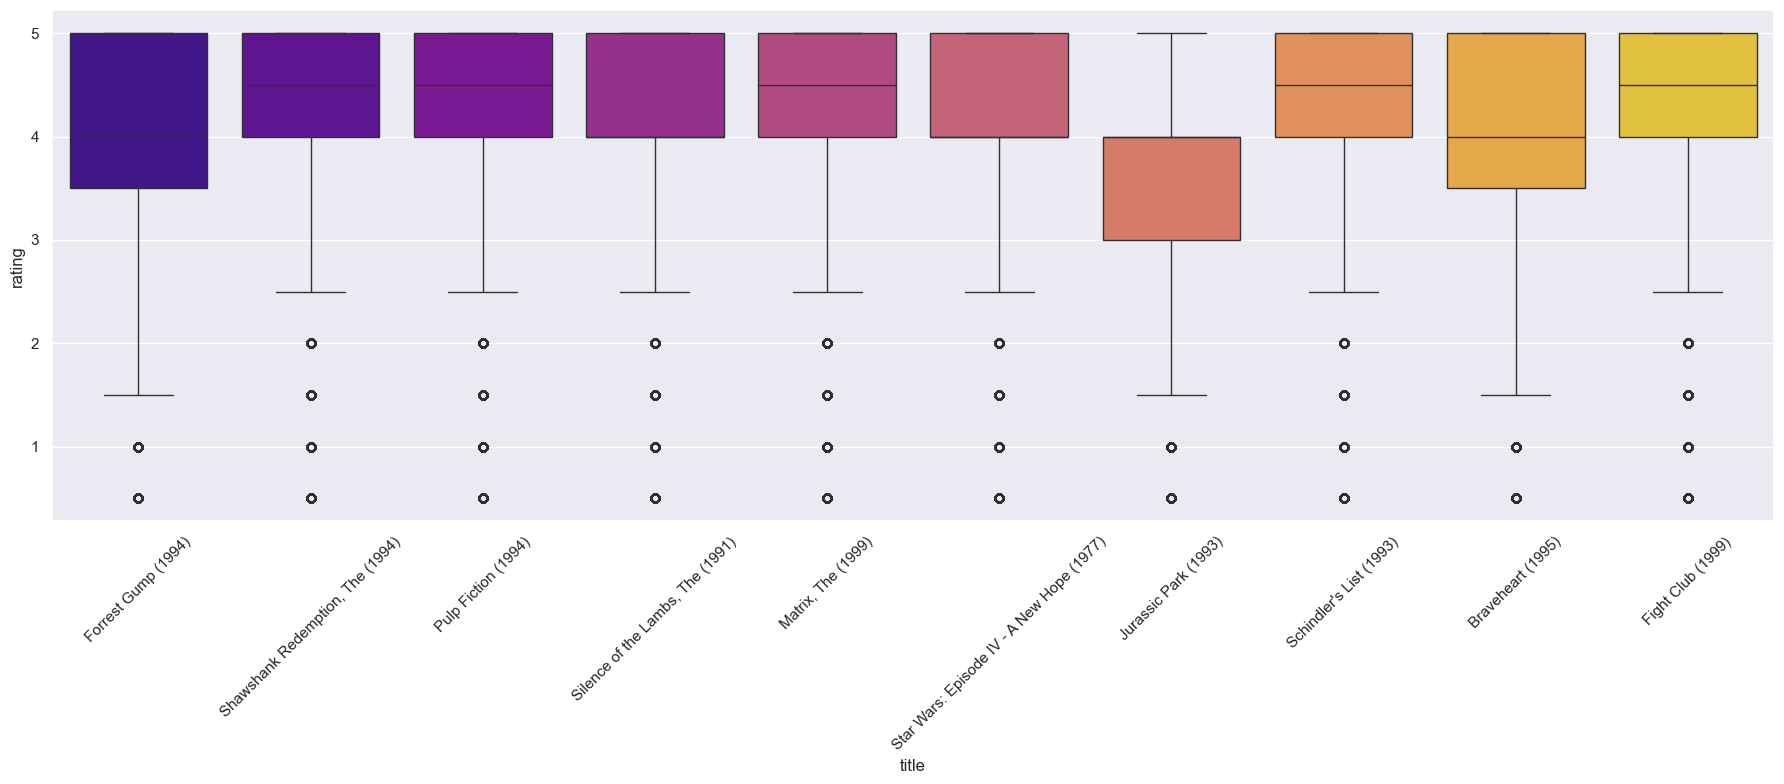

In [55]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.boxplot(x='title', y='rating', data=top10movr, palette ='plasma')
plt.xticks(rotation=45) 
plt.tight_layout()

## Recommendation Preparations

In [56]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [57]:
df_ratings.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [58]:
df_movies = df_movies.merge(df_ratings.groupby(['movieId'])['rating'].mean().reset_index(), on='movieId', how='inner')
df_movies.rename({'rating': 'average rating'})
df_movies.head()

,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547
4,5,Father of the Bride Part II (1995),Comedy,3.058434


In [59]:
df_movies = df_movies.merge(df_ratings.groupby(['movieId'])['rating'].count().reset_index(), on='movieId', how='inner')
df_movies.rename({'rating': 'number of ratings'})
df_movies.head()

,movieId,title,genres,rating_x,rating_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714


In [60]:
df_movies.rename({'rating_x': 'average_ratings', 'rating_y':'number_ratings'}, axis=1, inplace=True)
df_movies

,movieId,title,genres,average_ratings,number_ratings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714
...,...,...,...,...,...
59042,209157,We (2018),Drama,1.500000,1
59043,209159,Window of the Soul (2001),Documentary,3.000000,1
59044,209163,Bad Poems (2018),Comedy|Drama,4.500000,1
59045,209169,A Girl Thing (2001),(no genres listed),3.000000,1


In [61]:
df_movies1 = df_movies.merge(df_tags.groupby(['movieId'])['tag'].apply(list).reset_index(), on='movieId', how='left')
df_movies1

,movieId,title,genres,average_ratings,number_ratings,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,"[Owned, imdb top 250, Pixar, Pixar, time trave..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,"[Robin Williams, time travel, fantasy, based o..."
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,"[funny, best friend, duringcreditsstinger, fis..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,"[based on novel or book, chick flick, divorce,..."
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,"[aging, baby, confidence, contraception, daugh..."
...,...,...,...,...,...,...
59042,209157,We (2018),Drama,1.500000,1,NaN
59043,209159,Window of the Soul (2001),Documentary,3.000000,1,NaN
59044,209163,Bad Poems (2018),Comedy|Drama,4.500000,1,NaN
59045,209169,A Girl Thing (2001),(no genres listed),3.000000,1,NaN


In [62]:
df_movies2 = df_movies1.merge(df_tags.groupby(['movieId'])['tag'].count().reset_index(), on='movieId', how='left')
df_movies2.head()

,movieId,title,genres,average_ratings,number_ratings,tag_x,tag_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,"[Owned, imdb top 250, Pixar, Pixar, time trave...",697.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,"[Robin Williams, time travel, fantasy, based o...",180.0
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,"[funny, best friend, duringcreditsstinger, fis...",29.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,"[based on novel or book, chick flick, divorce,...",11.0
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,"[aging, baby, confidence, contraception, daugh...",24.0


In [63]:
df_movies2.rename({'tag_x': 'all_tags', 'tag_y':'number_tags'}, axis=1, inplace=True)
df_movies2

,movieId,title,genres,average_ratings,number_ratings,all_tags,number_tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,"[Owned, imdb top 250, Pixar, Pixar, time trave...",697.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,"[Robin Williams, time travel, fantasy, based o...",180.0
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,"[funny, best friend, duringcreditsstinger, fis...",29.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,"[based on novel or book, chick flick, divorce,...",11.0
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,"[aging, baby, confidence, contraception, daugh...",24.0
...,...,...,...,...,...,...,...
59042,209157,We (2018),Drama,1.500000,1,NaN,NaN
59043,209159,Window of the Soul (2001),Documentary,3.000000,1,NaN,NaN
59044,209163,Bad Poems (2018),Comedy|Drama,4.500000,1,NaN,NaN
59045,209169,A Girl Thing (2001),(no genres listed),3.000000,1,NaN,NaN


In [64]:
recommendation_set = df_movies2.copy()

In [65]:
recommendation_set.isnull().sum()

movieId                0
title                  0
genres                 0
average_ratings        0
number_ratings         0
all_tags           17172
number_tags        17172
dtype: int64

In [66]:
sss = dfm['genres'].str.split(pat='|', expand=False)
sss

recommendation_set['genres'] = sss
recommendation_set

,movieId,title,genres,average_ratings,number_ratings,all_tags,number_tags
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.893708,57309,"[Owned, imdb top 250, Pixar, Pixar, time trave...",697.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.251527,24228,"[Robin Williams, time travel, fantasy, based o...",180.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.142028,11804,"[funny, best friend, duringcreditsstinger, fis...",29.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.853547,2523,"[based on novel or book, chick flick, divorce,...",11.0
4,5,Father of the Bride Part II (1995),[Comedy],3.058434,11714,"[aging, baby, confidence, contraception, daugh...",24.0
...,...,...,...,...,...,...,...
59042,209157,We (2018),[Drama],1.500000,1,NaN,NaN
59043,209159,Window of the Soul (2001),[Documentary],3.000000,1,NaN,NaN
59044,209163,Bad Poems (2018),"[Comedy, Drama]",4.500000,1,NaN,NaN
59045,209169,A Girl Thing (2001),[(no genres listed)],3.000000,1,NaN,NaN


In [67]:
temp = recommendation_set['all_tags'].copy()

In [68]:
temp.dropna(inplace=True)
temp

0        [Owned, imdb top 250, Pixar, Pixar, time trave...
1        [Robin Williams, time travel, fantasy, based o...
2        [funny, best friend, duringcreditsstinger, fis...
3        [based on novel or book, chick flick, divorce,...
4        [aging, baby, confidence, contraception, daugh...
                               ...                        
58970                                         [might like]
58997               [black and white, deal with the devil]
59007    [computer animation, Japan, mass behavior, mas...
59008    [chameleon, computer animation, gluttony, humo...
59015    [black, education, friends schools, independen...
Name: all_tags, Length: 41875, dtype: object

In [69]:
back_to_dataset = temp.astype(str).str.replace(' ','')

In [70]:
tryagain = recommendation_set['all_tags'].copy()
tryagain

0        [Owned, imdb top 250, Pixar, Pixar, time trave...
1        [Robin Williams, time travel, fantasy, based o...
2        [funny, best friend, duringcreditsstinger, fis...
3        [based on novel or book, chick flick, divorce,...
4        [aging, baby, confidence, contraception, daugh...
                               ...                        
59042                                                  NaN
59043                                                  NaN
59044                                                  NaN
59045                                                  NaN
59046                                                  NaN
Name: all_tags, Length: 59047, dtype: object

In [71]:
recommendation_set['all_tags'] = tryagain.astype(str).str.replace(' ','')
recommendation_set

,movieId,title,genres,average_ratings,number_ratings,all_tags,number_tags
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.893708,57309,"['Owned','imdbtop250','Pixar','Pixar','timetra...",697.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.251527,24228,"['RobinWilliams','timetravel','fantasy',""based...",180.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.142028,11804,"['funny','bestfriend','duringcreditsstinger','...",29.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.853547,2523,"['basedonnovelorbook','chickflick','divorce','...",11.0
4,5,Father of the Bride Part II (1995),[Comedy],3.058434,11714,"['aging','baby','confidence','contraception','...",24.0
...,...,...,...,...,...,...,...
59042,209157,We (2018),[Drama],1.500000,1,nan,NaN
59043,209159,Window of the Soul (2001),[Documentary],3.000000,1,nan,NaN
59044,209163,Bad Poems (2018),"[Comedy, Drama]",4.500000,1,nan,NaN
59045,209169,A Girl Thing (2001),[(no genres listed)],3.000000,1,nan,NaN


In [72]:
recommendation_set['genres'] = recommendation_set['genres'].apply(lambda x:[i.replace(" ","") for i in x])
recommendation_set

,movieId,title,genres,average_ratings,number_ratings,all_tags,number_tags
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.893708,57309,"['Owned','imdbtop250','Pixar','Pixar','timetra...",697.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.251527,24228,"['RobinWilliams','timetravel','fantasy',""based...",180.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.142028,11804,"['funny','bestfriend','duringcreditsstinger','...",29.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.853547,2523,"['basedonnovelorbook','chickflick','divorce','...",11.0
4,5,Father of the Bride Part II (1995),[Comedy],3.058434,11714,"['aging','baby','confidence','contraception','...",24.0
...,...,...,...,...,...,...,...
59042,209157,We (2018),[Drama],1.500000,1,nan,NaN
59043,209159,Window of the Soul (2001),[Documentary],3.000000,1,nan,NaN
59044,209163,Bad Poems (2018),"[Comedy, Drama]",4.500000,1,nan,NaN
59045,209169,A Girl Thing (2001),[(nogenreslisted)],3.000000,1,nan,NaN


In [73]:
attempt2 = recommendation_set['all_tags'].copy()
recommendation_set['all_tags'] = attempt2.str.replace("'", "")
recommendation_set

,movieId,title,genres,average_ratings,number_ratings,all_tags,number_tags
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.893708,57309,"[Owned,imdbtop250,Pixar,Pixar,timetravel,child...",697.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.251527,24228,"[RobinWilliams,timetravel,fantasy,""basedonchil...",180.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.142028,11804,"[funny,bestfriend,duringcreditsstinger,fishing...",29.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.853547,2523,"[basedonnovelorbook,chickflick,divorce,interra...",11.0
4,5,Father of the Bride Part II (1995),[Comedy],3.058434,11714,"[aging,baby,confidence,contraception,daughter,...",24.0
...,...,...,...,...,...,...,...
59042,209157,We (2018),[Drama],1.500000,1,nan,NaN
59043,209159,Window of the Soul (2001),[Documentary],3.000000,1,nan,NaN
59044,209163,Bad Poems (2018),"[Comedy, Drama]",4.500000,1,nan,NaN
59045,209169,A Girl Thing (2001),[(nogenreslisted)],3.000000,1,nan,NaN


In [74]:
attempt3 = recommendation_set['all_tags'].copy()
recommendation_set['all_tags'] = attempt3.str.replace(",", ", ")

In [75]:
attempt4 = recommendation_set['all_tags'].copy()
recommendation_set['all_tags'] = attempt4.str.replace('"', '')
recommendation_set

,movieId,title,genres,average_ratings,number_ratings,all_tags,number_tags
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.893708,57309,"[Owned, imdbtop250, Pixar, Pixar, timetravel, ...",697.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.251527,24228,"[RobinWilliams, timetravel, fantasy, basedonch...",180.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.142028,11804,"[funny, bestfriend, duringcreditsstinger, fish...",29.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.853547,2523,"[basedonnovelorbook, chickflick, divorce, inte...",11.0
4,5,Father of the Bride Part II (1995),[Comedy],3.058434,11714,"[aging, baby, confidence, contraception, daugh...",24.0
...,...,...,...,...,...,...,...
59042,209157,We (2018),[Drama],1.500000,1,nan,NaN
59043,209159,Window of the Soul (2001),[Documentary],3.000000,1,nan,NaN
59044,209163,Bad Poems (2018),"[Comedy, Drama]",4.500000,1,nan,NaN
59045,209169,A Girl Thing (2001),[(nogenreslisted)],3.000000,1,nan,NaN


In [76]:
temp5 = recommendation_set.copy()
temp6 = recommendation_set.copy()
temp7 = recommendation_set.copy()

In [77]:
import re
from num2words import num2words

def convert1(x):
    x1 = re.sub(r"\b3", "three", x)
    x2 = re.sub(r"[©]", "", x1)
    x3 = re.sub(r"\b[0-9]", "", x2)
    x4 = re.sub(r"\b[0-9]", "", x3)
    x5 = re.sub(r"\b[0-9]", "", x4)
    x6 = re.sub(r"\b[0-9]", "", x5)
    x7 = re.sub(r"[é˜®ä¸€£:]", "", x6)
    x8 = re.sub(r"\B[,]", "", x7)
    return x8

temp6['all_tags'] = temp6['all_tags'].apply(convert1)
temp6['all_tags'][0]

'[Owned, imdbtop250, Pixar, Pixar, timetravel, children, comedy, funny, witty, rated-G, animation, Pixar, computeranimation, goodcartoonchindren, pixar, friendship, bright, DARINGRESCUES, fanciful, HEROICMISSION, humorous, light, rousing, TOYSCOMETOLIFE, UNLIKELYFRIENDSHIPS, warm, witty, animation, Disney, friendship, pixar, boy, boynextdoor, bullying, friends, friendship, jealousy, martialarts, mission, neighborhood, newtoy, pixar, rescue, resourcefulness, rivalry, toy, toycomestolife, walkietalkie, clever, animation, clever, friendship, funny, TomHanks, witty, pixar, Pixar, toys, animation, fun, children, pixar, TomHanks, dolls, NationalFilmRegistry, adventure, animated, animation, cgi, comedy, Disney, family, fantasy, friendship, imdbtop250, Pixar, TomHanks, witty, classic, pixar, witty, Pixar, funny, animated, comedy, Disney, fun, funny, pixar, animated, animation, children, comedy, fantasy, funny, humorous, Pixar, timetravel, Pixar, Pixar, TomHanks, animation, fun, animation, cgi,

In [78]:
res = str(temp6['all_tags'][0])[1:-1]
res


'Owned, imdbtop250, Pixar, Pixar, timetravel, children, comedy, funny, witty, rated-G, animation, Pixar, computeranimation, goodcartoonchindren, pixar, friendship, bright, DARINGRESCUES, fanciful, HEROICMISSION, humorous, light, rousing, TOYSCOMETOLIFE, UNLIKELYFRIENDSHIPS, warm, witty, animation, Disney, friendship, pixar, boy, boynextdoor, bullying, friends, friendship, jealousy, martialarts, mission, neighborhood, newtoy, pixar, rescue, resourcefulness, rivalry, toy, toycomestolife, walkietalkie, clever, animation, clever, friendship, funny, TomHanks, witty, pixar, Pixar, toys, animation, fun, children, pixar, TomHanks, dolls, NationalFilmRegistry, adventure, animated, animation, cgi, comedy, Disney, family, fantasy, friendship, imdbtop250, Pixar, TomHanks, witty, classic, pixar, witty, Pixar, funny, animated, comedy, Disney, fun, funny, pixar, animated, animation, children, comedy, fantasy, funny, humorous, Pixar, timetravel, Pixar, Pixar, TomHanks, animation, fun, animation, cgi, 

In [79]:
def convert(x):
    xy = str(x)[1:-1]
    return xy

temp6['all_tags'] = temp6['all_tags'].apply(convert)
temp6['all_tags']

0        Owned, imdbtop250, Pixar, Pixar, timetravel, c...
1        RobinWilliams, timetravel, fantasy, basedonchi...
2        funny, bestfriend, duringcreditsstinger, fishi...
3        basedonnovelorbook, chickflick, divorce, inter...
4        aging, baby, confidence, contraception, daught...
                               ...                        
59042                                                    a
59043                                                    a
59044                                                    a
59045                                                    a
59046                                                    a
Name: all_tags, Length: 59047, dtype: object

In [80]:
temp6['genres'] = temp6['genres'].apply(convert)
temp6['genres']

0        'Adventure', 'Animation', 'Children', 'Comedy'...
1                       'Adventure', 'Children', 'Fantasy'
2                                      'Comedy', 'Romance'
3                             'Comedy', 'Drama', 'Romance'
4                                                 'Comedy'
                               ...                        
59042                                              'Drama'
59043                                        'Documentary'
59044                                    'Comedy', 'Drama'
59045                                   '(nogenreslisted)'
59046                       'Action', 'Adventure', 'Drama'
Name: genres, Length: 59047, dtype: object

In [81]:
recommendation_set['labels'] = temp6['all_tags'] + temp6['genres']
recommendation_set.head()

,movieId,title,genres,average_ratings,number_ratings,all_tags,number_tags,labels
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.893708,57309,"[Owned, imdbtop250, Pixar, Pixar, timetravel, ...",697.0,"Owned, imdbtop250, Pixar, Pixar, timetravel, c..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.251527,24228,"[RobinWilliams, timetravel, fantasy, basedonch...",180.0,"RobinWilliams, timetravel, fantasy, basedonchi..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.142028,11804,"[funny, bestfriend, duringcreditsstinger, fish...",29.0,"funny, bestfriend, duringcreditsstinger, fishi..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.853547,2523,"[basedonnovelorbook, chickflick, divorce, inte...",11.0,"basedonnovelorbook, chickflick, divorce, inter..."
4,5,Father of the Bride Part II (1995),[Comedy],3.058434,11714,"[aging, baby, confidence, contraception, daugh...",24.0,"aging, baby, confidence, contraception, daught..."


In [148]:
def remove_year(num):
    x = re.sub("\((\d{4})\)", "", num)
    return x

recommendation_set['search_title'] = temp7['title'].apply(remove_year)
recommendation_set['year'] = sep_year
recommendation_set['title'] = df_movies['title']

<>:2: SyntaxWarning: invalid escape sequence '\('
<>:2: SyntaxWarning: invalid escape sequence '\('
C:\Users\Me\AppData\Local\Temp\ipykernel_4320\3205163457.py:2: SyntaxWarning: invalid escape sequence '\('
  x = re.sub("\((\d{4})\)", "", num)


In [149]:
recommendation_set

,movieId,title,genres,average_ratings,number_ratings,all_tags,number_tags,labels,search_title,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.893708,57309,"[Owned, imdbtop250, Pixar, Pixar, timetravel, ...",697.0,"Owned, imdbtop250, Pixar, Pixar, timetravel, c...",Toy Story,1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.251527,24228,"[RobinWilliams, timetravel, fantasy, basedonch...",180.0,"RobinWilliams, timetravel, fantasy, basedonchi...",Jumanji,1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.142028,11804,"[funny, bestfriend, duringcreditsstinger, fish...",29.0,"funny, bestfriend, duringcreditsstinger, fishi...",Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.853547,2523,"[basedonnovelorbook, chickflick, divorce, inte...",11.0,"basedonnovelorbook, chickflick, divorce, inter...",Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),[Comedy],3.058434,11714,"[aging, baby, confidence, contraception, daugh...",24.0,"aging, baby, confidence, contraception, daught...",Father of the Bride Part II,1995
...,...,...,...,...,...,...,...,...,...,...
59042,209157,We (2018),[Drama],1.500000,1,nan,NaN,a'Drama',We,2019
59043,209159,Window of the Soul (2001),[Documentary],3.000000,1,nan,NaN,a'Documentary',Window of the Soul,2019
59044,209163,Bad Poems (2018),"[Comedy, Drama]",4.500000,1,nan,NaN,"a'Comedy', 'Drama'",Bad Poems,2019
59045,209169,A Girl Thing (2001),[(nogenreslisted)],3.000000,1,nan,NaN,a'(nogenreslisted)',A Girl Thing,2019


In [150]:
final = recommendation_set[['movieId', 'search_title', 'year', 'labels', 'average_ratings', 'number_ratings', 'title']]
final.head()

,movieId,search_title,year,labels,average_ratings,number_ratings,title
0,1,Toy Story,1995,"Owned, imdbtop250, Pixar, Pixar, timetravel, c...",3.893708,57309,Toy Story (1995)
1,2,Jumanji,1995,"RobinWilliams, timetravel, fantasy, basedonchi...",3.251527,24228,Jumanji (1995)
2,3,Grumpier Old Men,1995,"funny, bestfriend, duringcreditsstinger, fishi...",3.142028,11804,Grumpier Old Men (1995)
3,4,Waiting to Exhale,1995,"basedonnovelorbook, chickflick, divorce, inter...",2.853547,2523,Waiting to Exhale (1995)
4,5,Father of the Bride Part II,1995,"aging, baby, confidence, contraception, daught...",3.058434,11714,Father of the Bride Part II (1995)


In [151]:
final['labels'] = final['labels'].apply(lambda x:x.lower())
final['labels']

C:\Users\Me\AppData\Local\Temp\ipykernel_4320\523004705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['labels'] = final['labels'].apply(lambda x:x.lower())


0        owned, imdbtop250, pixar, pixar, timetravel, c...
1        robinwilliams, timetravel, fantasy, basedonchi...
2        funny, bestfriend, duringcreditsstinger, fishi...
3        basedonnovelorbook, chickflick, divorce, inter...
4        aging, baby, confidence, contraception, daught...
                               ...                        
59042                                             a'drama'
59043                                       a'documentary'
59044                                   a'comedy', 'drama'
59045                                  a'(nogenreslisted)'
59046                      a'action', 'adventure', 'drama'
Name: labels, Length: 59047, dtype: object

In [152]:
def remove_stuff(p):
    o = p.str.replace(",", "")
    return o

final['labels'] = final['labels'].str.replace(",", "")
final['labels']

C:\Users\Me\AppData\Local\Temp\ipykernel_4320\4272081587.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['labels'] = final['labels'].str.replace(",", "")


0        owned imdbtop250 pixar pixar timetravel childr...
1        robinwilliams timetravel fantasy basedonchildr...
2        funny bestfriend duringcreditsstinger fishing ...
3        basedonnovelorbook chickflick divorce interrac...
4        aging baby confidence contraception daughter g...
                               ...                        
59042                                             a'drama'
59043                                       a'documentary'
59044                                    a'comedy' 'drama'
59045                                  a'(nogenreslisted)'
59046                        a'action' 'adventure' 'drama'
Name: labels, Length: 59047, dtype: object

In [153]:
final['labels'] = final['labels'].str.replace("'", "")
final['labels']

C:\Users\Me\AppData\Local\Temp\ipykernel_4320\3990407601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['labels'] = final['labels'].str.replace("'", "")


0        owned imdbtop250 pixar pixar timetravel childr...
1        robinwilliams timetravel fantasy basedonchildr...
2        funny bestfriend duringcreditsstinger fishing ...
3        basedonnovelorbook chickflick divorce interrac...
4        aging baby confidence contraception daughter g...
                               ...                        
59042                                               adrama
59043                                         adocumentary
59044                                        acomedy drama
59045                                    a(nogenreslisted)
59046                              aaction adventure drama
Name: labels, Length: 59047, dtype: object

In [154]:
final['labels'][0]

'owned imdbtop250 pixar pixar timetravel children comedy funny witty rated-g animation pixar computeranimation goodcartoonchindren pixar friendship bright daringrescues fanciful heroicmission humorous light rousing toyscometolife unlikelyfriendships warm witty animation disney friendship pixar boy boynextdoor bullying friends friendship jealousy martialarts mission neighborhood newtoy pixar rescue resourcefulness rivalry toy toycomestolife walkietalkie clever animation clever friendship funny tomhanks witty pixar pixar toys animation fun children pixar tomhanks dolls nationalfilmregistry adventure animated animation cgi comedy disney family fantasy friendship imdbtop250 pixar tomhanks witty classic pixar witty pixar funny animated comedy disney fun funny pixar animated animation children comedy fantasy funny humorous pixar timetravel pixar pixar tomhanks animation fun animation cgi family animation pixar watched pixar witty animation animation classic clever comedy computeranimation di

## Recommendation

In [155]:
ps = PorterStemmer()

In [156]:
## example
ps.stem('associated')

'associ'

In [157]:
def stem(text):
    y = []

    for i in text.split():
        y.append(ps.stem(i))

    return " ".join(y)

In [158]:
final['labels'] = final['labels'].apply(stem)

C:\Users\Me\AppData\Local\Temp\ipykernel_4320\3106567424.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['labels'] = final['labels'].apply(stem)


In [159]:
cv = CountVectorizer(max_features=10000,stop_words='english')

In [160]:
testt = cv.fit_transform(final['labels'].head(30000)).toarray()
similar1 = cosine_similarity(testt)

In [161]:
testt2 = cv.fit_transform(final['labels'].tail(29047)).toarray()
similar2 = cosine_similarity(testt2)

In [164]:
cv.get_feature_names_out()

array(['a24', 'aaction', 'aadventur', ..., 'zombiescomedi',
       'zombieshorror', 'zomvi'], dtype=object)

In [166]:
sorted(list(enumerate(similar1[0])),reverse=True, key=lambda x:x[1])

[(0, 1.0),
 (3021, 0.8901289744173629),
 (2264, 0.8669165407666101),
 (4780, 0.8082348020784127),
 (6258, 0.793660095505459),
 (14803, 0.7659830724645512),
 (5110, 0.7579827953911614),
 (19817, 0.6978744029009017),
 (8246, 0.6772076521118567),
 (22441, 0.6595069686652245),
 (11359, 0.6538419925683432),
 (10808, 0.6490878331601844),
 (13357, 0.6328490315910534),
 (23741, 0.6222736190817136),
 (18278, 0.6135166958497663),
 (10375, 0.5891456965447415),
 (13972, 0.5573713585046556),
 (18196, 0.5516694969166731),
 (4201, 0.5490365015697575),
 (25904, 0.541197973895084),
 (22381, 0.5363430274535173),
 (23740, 0.5194418491576343),
 (29160, 0.5180664471647064),
 (29215, 0.5160385695770664),
 (588, 0.5076711826549803),
 (18195, 0.5057346926658002),
 (17475, 0.5050386742107341),
 (18496, 0.5050386742107341),
 (23505, 0.5050386742107341),
 (1996, 0.5018061956153993),
 (23484, 0.5009534667928971),
 (18242, 0.4999656523628507),
 (12372, 0.4958156739365077),
 (25542, 0.49509301247837023),
 (9687, 0.

In [188]:
def remove_whitespace(word):
    x = str(word).strip()
    return x

final['search_title'] = final['search_title'].apply(remove_whitespace)

C:\Users\Me\AppData\Local\Temp\ipykernel_4320\3621698459.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['search_title'] = final['search_title'].apply(remove_whitespace)


In [189]:
def recommend(movie):

    movie_index = final[final['search_title'] == movie].index[0]
    distances1 = similar1[movie_index]
    distances2 = similar2[movie_index]

    movies_list1  = sorted(list(enumerate(distances1)),reverse=True, key=lambda x:x[1])[1:4]
    movies_list2  = sorted(list(enumerate(distances2)),reverse=True, key=lambda x:x[1])[1:4]

    for i in movies_list1:
        print(final.iloc[i[0]].title)

    for j in movies_list2:
        print(final.iloc[j[0]].title)

res = str(temp6['all_tags'][0])[1:-1]

In [194]:
recommend('Flubber')

Jack (1996)
Final Cut, The (2004)
Mrs. Doubtfire (1993)
3:10 to Yuma (1957)
EuroTrip (2004)
Trojan Women, The (1971)
